In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import numpy as np
import os
import pandas as pd
import scipy as sp
import sys
import torch
import torch.nn.functional as F
import warnings
import random
import collections

# CD-T Imports
import math
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import itertools
import operator

from torch import nn

warnings.filterwarnings("ignore")

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from argparse import Namespace
from pyfunctions.cdt_basic import *
from pyfunctions.cdt_source_to_target import *
from pyfunctions.faithfulness_ablations import *
from pyfunctions.ioi_dataset import IOIDataset
from pyfunctions.faithfulness_ablations import logits_to_ave_logit_diff_2, add_mean_ablation_hook# add_knock_out_hook

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModel
from transformers import GPT2Tokenizer, GPT2Model
from pyfunctions.wrappers import Node, AblationSet

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.autograd.set_grad_enabled(False)
# Model code adapted from Callum McDougall's notebook for ARENA on reproducing the IOI paper using TransformerLens.
# This makes some sense, since EasyTransformer, the repo/lib released by the IOI authors, was forked from TransformerLens.
# In fact, this makes the reproduction a little bit more faithful, since they most likely do certain things such as 
# "folding" LayerNorms to improve their interpretability results, and we are able to do the same by using TransformerLens.

from transformer_lens import utils, HookedTransformer, ActivationCache
model = HookedTransformer.from_pretrained("gpt2-small",
                                          center_unembed=True,
                                          center_writing_weights=True,
                                          fold_ln=False,
                                          refactor_factored_attn_matrices=True)

In [94]:
ioi_dataset = IOIDataset(prompt_type="mixed", N=100, tokenizer=model.tokenizer, prepend_bos=False)
abc_dataset = (
    ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)

2024-09-30 06:15:44.174680: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-30 06:15:50.004199: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 06:16:03.352692: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [39]:
# GPT-2 (Clean)
model.reset_hooks(including_permanent=True)
logits, cache = model.run_with_cache(ioi_dataset.toks) # run on entire dataset along batch dimension
ave_logit_diff = logits_to_ave_logit_diff_2(logits, ioi_dataset)
print(ave_logit_diff)

tensor(3.3168, device='cuda:0')


In [95]:
SEQ_LEN = ioi_dataset.toks.shape[-1]

In [73]:
# baseline circuit  (ablate every node)
circuit = []
for l in range(12):
    for pos in range(SEQ_LEN):
        for head in range(12):
            circuit.append(Node(l, pos, head))
        
base_model = add_mean_ablation_hook(model, means_dataset=abc_dataset, circuit=[])
logits, cache = base_model.run_with_cache(ioi_dataset.toks) # run on entire dataset along batch dimension
ave_logit_diff = logits_to_ave_logit_diff_2(logits, ioi_dataset)
print(ave_logit_diff)

tensor(-0.6226, device='cuda:0')


In [41]:
MODEL_CLEAN = 3.3168
MODEL_NULL = -0.6226

In [18]:
def prepare_heads_into_nodes(heads, seq_len):
    circuit = []
    for x in heads:
        l = int(x.split('.')[0])
        head = int(x.split('.')[1])
        for pos in range(seq_len):
            circuit.append(Node(l, pos, head))
    return circuit

def compute_ioi_score(model, circuit, mean_data, run_data, knock_out=False):
    if knock_out:
        model = add_knock_out_hook(model, means_dataset=mean_data, circuit=circuit)
    else:
        model = add_mean_ablation_hook(model, means_dataset=mean_data, circuit=circuit)
    logits, cache = model.run_with_cache(run_data.toks) # run on entire dataset along batch dimension
    ave_logit_diff = logits_to_ave_logit_diff_2(logits, run_data)
    return ave_logit_diff

def compute_faithfulness(circuit_score, model_clean, model_null):
    return (circuit_score - model_null) / (model_clean - model_null)

In [43]:
import matplotlib.pyplot as plt
import tqdm

## Faithfulness vs node count

In [119]:
# random
import random
random.seed(24)

all_heads = []
for i in range(12):
    for j in range(12):
        all_heads.append(f'{i}.{j}')
random.shuffle(all_heads)

circuit = []
rand_faith_scores = []
for head in tqdm.tqdm(all_heads):
    circuit.extend(prepare_heads_into_nodes([head], SEQ_LEN))
    circuit_score = compute_ioi_score(model, circuit, abc_dataset, ioi_dataset)
    faithfulness = compute_faithfulness(circuit_score, MODEL_CLEAN, MODEL_NULL)
    rand_faith_scores.append(faithfulness)

100%|██████████| 144/144 [07:25<00:00,  3.09s/it]


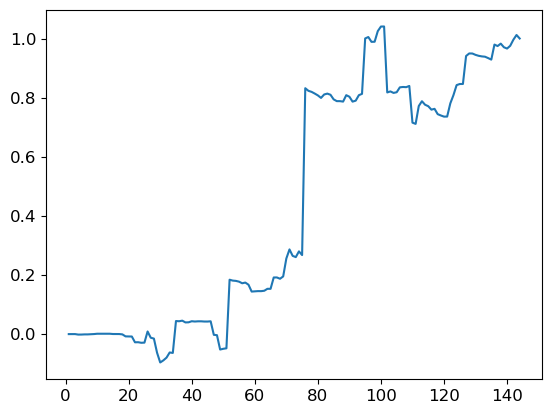

In [121]:
rand_faith_scores = [x.detach().cpu().numpy() for x in rand_faith_scores]
plt.plot(range(1, len(all_heads)+1), rand_faith_scores)

In [122]:
with open(f'REDACTED', 'w') as f:
    json.dump({i:float(x) for i, x in enumerate(rand_faith_scores)}, f)

In [101]:
# read in node importance
import json
th = 90
with open(f'REDACTED', 'r') as f:
    cdt_heads = json.load(f)
    
circuit = []
faith_scores = []
for head, importance in tqdm.tqdm(cdt_heads):
    circuit.extend(prepare_heads_into_nodes([head], SEQ_LEN))
    circuit_score = compute_ioi_score(model, circuit, abc_dataset, ioi_dataset)
    faithfulness = compute_faithfulness(circuit_score, MODEL_CLEAN, MODEL_NULL)
    faith_scores.append(faithfulness)

100%|██████████| 144/144 [07:23<00:00,  3.08s/it]


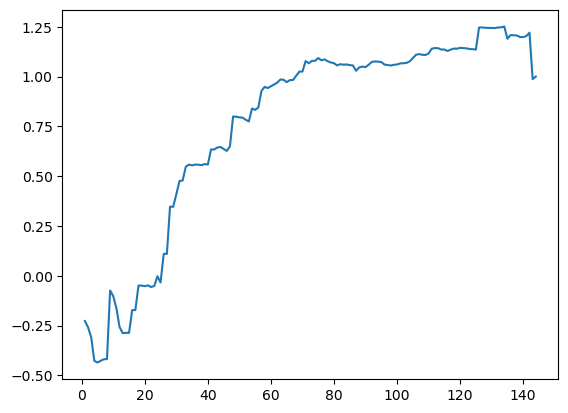

In [102]:
# 90
faith_scores = [x.detach().cpu().numpy() for x in faith_scores]
plt.plot(range(1, len(cdt_heads)+1), faith_scores)

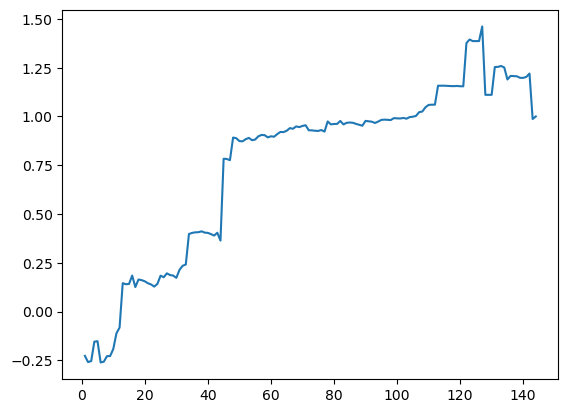

In [97]:
# 99
faith_scores = [x.detach().cpu().numpy() for x in faith_scores]
plt.plot(range(1, len(cdt_heads)+1), faith_scores)

In [103]:
with open(f'REDACTED', 'w') as f:
    json.dump({i:float(x) for i, x in enumerate(faith_scores)}, f)

In [79]:
# read in node importance
import json
with open('REDACTED', 'r') as f:
    eap_heads = json.load(f)
eap_heads_scores = eap_heads['0.077']    

eap_circuit = []
eap_faith_scores = []
for head, importance in tqdm.tqdm(eap_heads_scores):
    eap_circuit.extend(prepare_heads_into_nodes([head], SEQ_LEN))
    circuit_score = compute_ioi_score(model, eap_circuit, abc_dataset, ioi_dataset)
    faithfulness = compute_faithfulness(circuit_score, MODEL_CLEAN, MODEL_NULL)
    eap_faith_scores.append(faithfulness)


100%|██████████| 144/144 [08:54<00:00,  3.71s/it]


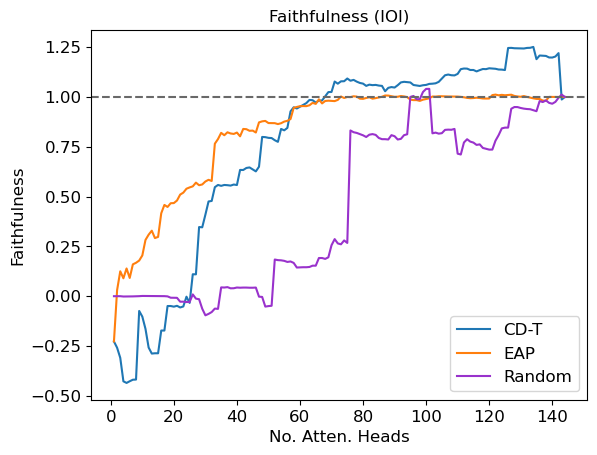

In [129]:
#eap_faith_scores = [x.detach().cpu().numpy() for x in eap_faith_scores]
plt.rcParams.update({'font.size': 12})

fig = plt.figure()

plt.plot(range(1, len(cdt_heads)+1), faith_scores, label=f'CD-T')
plt.plot(range(1, len(eap_heads_scores)+1), eap_faith_scores, label=f'EAP')
plt.plot(range(1, len(all_heads)+1), rand_faith_scores, label=f'Random', color='darkorchid')
plt.axhline(y=1, color='dimgrey', linestyle='--')

plt.title("Faithfulness (IOI)", fontsize=12)
plt.xlabel("No. Atten. Heads", fontsize=12)
plt.ylabel("Faithfulness")

plt.legend(loc="lower right")

# Show the plot
plt.show()
fig.savefig('REDACTED', dpi=300, bbox_inches='tight')

In [88]:
with open('REDACTED', 'w') as f:
    json.dump({i:float(x) for i, x in enumerate(eap_faith_scores)}, f)

In [96]:
# define the circuit here
CIRCUIT = {
    "name mover": [(9, 9), (10, 0), (9, 6)],
    #"backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    #"negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 10)],
    "induction": [(5, 5), (5, 8), (5, 9)],
    "duplicate token": [(0, 1), (0, 10), (3, 0)],
    "previous token": [(0, 6), (0, 7), (0, 10)],
}

SEQ_POS_TO_KEEP = {
    "name mover": "end",
    "backup name mover": "end",
    "negative name mover": "end",
    "s2 inhibition": "end",
    "induction": "S2",
    "duplicate token": "S2",
    "previous token": "S+1",
}

all_heads = []
for i in range(12):
    for j in range(12):
        all_heads.append(f'{i}.{j}')

## Hypothesis testing: (recovered circuit more faithful than random circuit)

In [ ]:
# CD-T
cdt_ioi_circuit_score = compute_ioi_score(model, CIRCUIT, abc_dataset, ioi_dataset)
faith = compute_faithfulness(cdt_ioi_circuit_score, MODEL_CLEAN, MODEL_NULL)
print(faith)

# sample random circuits with size N from M
percent = range(10, 101, 10)
seeds = range(10)
p_more_faithful_collect = []
#p_is_in_rand_c = []
for p in tqdm.tqdm(percent):
    N = int(p/100 * len(all_heads))
    # sample 10 random circuits for each N
    cnt = 0
    #in_cnt = 0
    for s in seeds:
        random.seed(s)
        rand_circuit = prepare_heads_into_nodes(random.sample(all_heads, N), SEQ_LEN)
        rand_circuit_score = compute_ioi_score(model, rand_circuit, abc_dataset, ioi_dataset)
        rand_faith = compute_faithfulness(rand_circuit_score, MODEL_CLEAN, MODEL_NULL)
        
        if faith > rand_faith:
            cnt += 1
        
        #if set(cdt_ioi_circuit).issubset(rand_circuit):
        #    in_cnt += 1
            
    p_N = cnt / len(seeds)
    #p_in = in_cnt / len(seeds)
    print(p_N)
    p_more_faithful_collect.append(p_N)
    #p_is_in_rand_c.append(p_in)

In [62]:
def compute_probabilities_better_than_random(our_circuit_faithfulness, generate_random_circuit_fn, compute_faithfulness_fn):
    percent = range(10, 101, 10)
    seeds = range(10)
    p_more_faithful_collect = []
    #p_is_in_rand_c = []
    for p in tqdm.tqdm(percent):
        proportion_of_heads = p / 100
        # N = int(p/100 * len(all_heads))
        # sample 10 random circuits for each N
        cnt = 0
        #in_cnt = 0
        for s in seeds:
            random.seed(s)
            rand_circuit = generate_random_circuit_fn(proportion_of_heads)
            # rand_circuit_score = compute_ioi_score(model, rand_circuit, abc_dataset, ioi_dataset)
            rand_faith = compute_faithfulness_fn(rand_circuit) # rand_circuit_score, MODEL_CLEAN, MODEL_NULL)

            if our_circuit_faithfulness > rand_faith:
                cnt += 1

            #if set(cdt_ioi_circuit).issubset(rand_circuit):
            #    in_cnt += 1

        p_N = cnt / len(seeds)
        #p_in = in_cnt / len(seeds)
        print(p_N)
        p_more_faithful_collect.append(p_N)
    return p_more_faithful_collect

### Docstring

In [108]:
# from mi_utils_public import *
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.autograd.set_grad_enabled(False)
model = HookedTransformer.from_pretrained('attn-only-4l',
                                         fold_ln=False)

"""Toggle whether to explicitly calculate and expose the result for each attention head.
Useful for interpretability but can easily burn through GPU memory.

        """
model.cfg.use_attn_result = False # Not actually needed because we have methods for accessing the activation cache anyway.
# note from the mi_utils guys: "because running subprocess breaks things"
# %env TOKENIZERS_PARALLELISM=true


from im_utils.prompts import Prompt, docstring_ind_prompt_gen

batch_size = 2000

docstring_ind_prompt_kwargs = dict(
    n_matching_args=3,
    n_def_prefix_args=2,
    n_def_suffix_args=1,
    n_doc_prefix_args=0,
    met_desc_len=3,
    arg_desc_len=2
)
prompts = [docstring_ind_prompt_gen("rest", **docstring_ind_prompt_kwargs) for _ in range(batch_size)]

Loaded pretrained model attn-only-4l into HookedTransformer


In [116]:
num_layers = len(model.blocks)
seq_len = len(pos_labels)
num_attention_heads = model.cfg.n_heads

In [109]:
pos_labels = model.to_str_tokens(prompts[0].clean_prompt)
pos_labels[ 0] = "BOS"
pos_labels[ 1] = "⏎"
pos_labels[ 2] = "def"
pos_labels[ 3] = "rand0"
pos_labels[ 4] = "("
pos_labels[ 5] = "self"
pos_labels[ 6] = ",_0"
pos_labels[ 7] = "rand1"
pos_labels[ 8] = ",_1"
pos_labels[ 9] = "rand2"
pos_labels[10] = ",_2"
pos_labels[11] = "A_def"
pos_labels[12] = ",_A"
pos_labels[13] = "B_def"
pos_labels[14] = ",_B"
pos_labels[15] = "C_def"
pos_labels[16] = ",_C"
pos_labels[17] = "rand3"
pos_labels[18] = "):"
pos_labels[19] = "⏎···_0"
pos_labels[20] = '"""'
pos_labels[21] = "rand4"
pos_labels[22] = "rand5"
pos_labels[23] = "rand6"
pos_labels[24] = "⏎⏎···_1"
pos_labels[25] = "·:_0"
pos_labels[26] = "param_1"
pos_labels[27] = "A_doc"
pos_labels[28] = ":_1"
pos_labels[29] = "rand7"
pos_labels[30] = "rand8"
pos_labels[31] = "⏎···_2"
pos_labels[32] = "·:_1"
pos_labels[33] = "param_2"
pos_labels[34] = "B_doc"
pos_labels[35] = ":_2"
pos_labels[36] = "rand9"
pos_labels[37] = "rand10"
pos_labels[38] = "⏎···_3"
pos_labels[39] = "·:_2"
pos_labels[40] = "param_3"

In [ ]:
# Get a "better" dataset, i.e, ones where the model answers the correct answer, preferably by a wide margin.
# the toy model actually isn't very good at the docstring task, only getting it right like 50-75% of the time.
# We obviously can't investigate the question of how the model does the docstring task if it's not actually "doing" it.
good_prompts = []
for prompt in prompts:
    clean_prompt = prompt.clean_prompt
    tokens = model.to_str_tokens(clean_prompt)
    # it's perhaps better to check if the model's prediction logit is highest by a certain threshold.
    correct_answer = tokens[pos_labels.index("C_def")]
    model_prediction = model.to_string(model.generate(clean_prompt, max_new_tokens=1, do_sample=False, return_type='tensor')[0][-1])
    if model_prediction == correct_answer:
        good_prompts.append(prompt)
prompts = good_prompts

In [117]:
TEST_DATASET_SIZE = 100
test_dataset = [prompt.clean_prompt for prompt in prompts[:TEST_DATASET_SIZE:]]

corrupt_prompts = [prompt.corrupt_prompt['random_answer_doc'] for prompt in prompts[:TEST_DATASET_SIZE]]

corrupt_logits, corrupt_cache = model.run_with_cache(corrupt_prompts)
corrupt_attention_outputs = [corrupt_cache['blocks.' + str(i) + '.attn.hook_z'] for i in range(num_layers)]
corrupt_attention_outputs = torch.stack(corrupt_attention_outputs, dim=0) # now batch, layer, seq_ nheads, dim_model

In [118]:
def logits_to_ave_logit_diff(logits, test_dataset):
    total = 0
    for i in range(len(test_dataset)):
        text = test_dataset[i]
        tokens = model.to_str_tokens(text) # NOT to_tokens(text)
        correct_logit_idx = model.to_single_token(tokens[pos_labels.index("C_def")])
        rel_correct_logit = logits[i, -1, correct_logit_idx]
        incorrect_seq_idxs = [pos_labels.index("A_def"), pos_labels.index("B_def"),
                         pos_labels.index("rand0"),
                         pos_labels.index("rand1"),
                         pos_labels.index("rand2"),
                         pos_labels.index("rand3"),
                         pos_labels.index("rand4"),
                         pos_labels.index("rand5"),
                         pos_labels.index("rand6"),
                         pos_labels.index("rand7"),
                         pos_labels.index("rand8"),
                         pos_labels.index("rand9"),
                         pos_labels.index("rand10"),
                         ]
        incorrect_logit_idxs = [model.to_single_token(tokens[idx]) for idx in incorrect_seq_idxs]
        rel_incorrect_logits = logits[0, -1, incorrect_logit_idxs]
        total += np.min(rel_correct_logit - rel_incorrect_logits)
    avg = total / len(test_dataset)
    return avg

In [119]:
def generate_random_circuit(proportion_of_heads):
    all_heads = [str(x) + '.' + str(y) for x in range(num_layers) for y in range(num_attention_heads)]
    heads = random.sample(all_heads, int(proportion_of_heads * len(all_heads)))
    return prepare_heads_into_nodes(heads, seq_len)

In [120]:
def compute_docstring_score(model, patch_dataset, test_dataset, circuit=None):
    model.reset_hooks(including_permanent=True)
    if circuit is not None:
        model = add_mean_ablation_hook(model, patch_values=patch_dataset, circuit=circuit)
    logits, cache = model.run_with_cache(test_dataset)
    ave_logit_diff = logits_to_ave_logit_diff(logits.cpu().numpy(), test_dataset)
    model.reset_hooks(including_permanent=True)
    return ave_logit_diff

In [ ]:
compute_docstring_score_fn = lambda circuit: compute_docstring_score(model, corrupt_attention_outputs, test_dataset, circuit)
MODEL_CLEAN = compute_docstring_score_fn(None)
MODEL_NULL = compute_docstring_score_fn([])
compute_docstring_faithfulness_fn = lambda circuit: compute_faithfulness(compute_docstring_score_fn(circuit), MODEL_CLEAN, MODEL_NULL)

our_circuit_faithfulness = 0.84738 # Result from the docstring_exploration notebook

p_more_faithful_collect_docstring = compute_probabilities_better_than_random(our_circuit_faithfulness, generate_random_circuit, compute_docstring_faithfulness_fn)

### Greater-than task

In [124]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.autograd.set_grad_enabled(False)

from transformer_lens import utils, HookedTransformer, ActivationCache
model = HookedTransformer.from_pretrained("gpt2-small",
                                          center_unembed=True,
                                          center_writing_weights=True,
                                          fold_ln=False,
                                          refactor_factored_attn_matrices=True)

Loaded pretrained model gpt2-small into HookedTransformer


In [125]:
num_layers = len(model.blocks)
seq_len = len(pos_labels)
num_attention_heads = model.cfg.n_heads

In [126]:
from greater_than_task.greater_than_dataset import *
from greater_than_task.utils import get_valid_years
# https://github.com/hannamw/gpt2-greater-than/blob/main/circuit_discovery.py; also these files came with their repo
years_to_sample_from = get_valid_years(model.tokenizer, 1000, 1900)
N = 1000
ds = YearDataset(years_to_sample_from, N, Path("../greater_than_task/cache/potential_nouns.txt"), model.tokenizer, balanced=True, device=device, eos=True)
year_indices = torch.load("../greater_than_task/cache/logit_indices.pt")# .to(device)

num_layers = len(model.blocks)
seq_len = ds.good_toks.size()[-1]
num_attention_heads = model.cfg.n_heads

In [127]:
# del out_decomps
# del target_decomps
# del logits
# del cache # pretty sure it's this one
print(torch.cuda.memory_allocated(0)/1024/1024)
print(torch.cuda.memory_reserved(0)/1024/1024)

import gc
gc.collect()

torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(0)/1024/1024)
print(torch.cuda.memory_reserved(0)/1024/1024)

3209.12158203125
8262.0
3209.12158203125
5676.0


In [128]:
NUM_AT_TIME = 50
start_idx = 0
score = 0
attention_outputs = []
while True:
    end_idx = start_idx + NUM_AT_TIME
    if end_idx > N:
        end_idx = N

    logits, cache = model.run_with_cache(ds.good_toks[start_idx:end_idx]) # run on entire dataset along batch dimension
    batch_attention_outputs = [cache['blocks.' + str(i) + '.attn.hook_z'] for i in range(num_attention_heads)]
    batch_attention_outputs = torch.stack(batch_attention_outputs, dim=1) # now batch, layer, seq, n_heads, dim_attn
    batch_mean_acts = torch.mean(batch_attention_outputs, dim=0)
    attention_outputs.append(batch_mean_acts)
    start_idx += NUM_AT_TIME
    if end_idx == N:
        break
attention_outputs = torch.stack(attention_outputs, dim=0) # now batch, layer, seq, n_heads, dim_attn
# logits, cache = model.run_with_cache(ds.good_toks) # run on entire dataset along batch dimension
# attention_outputs = [cache['blocks.' + str(i) + '.attn.hook_z'] for i in range(num_attention_heads)]
# attention_outputs = torch.stack(attention_outputs, dim=1) # now batch, layer, seq, n_heads, dim_attn
print(attention_outputs.shape)
mean_acts = torch.mean(attention_outputs, dim=0)
old_shape = mean_acts.shape
last_dim = old_shape[-2] * old_shape[-1]
new_shape = old_shape[:-2] + (last_dim,)
mean_acts = mean_acts.view(new_shape)
mean_acts.shape

torch.Size([20, 12, 13, 12, 64])


torch.Size([12, 13, 768])

In [129]:
# This is not a pure function. It depends on ds.good_mask, sample_idxs, and year_indices.
def score_logits(logits, sample_idxs_0):
    probs = torch.nn.functional.softmax(torch.tensor(logits[:, -1, :], device='cpu'), dim=-1).numpy() # sad
    probs_for_year_tokens = probs[:, year_indices.cpu().numpy()]
    probs_for_correct_years = probs_for_year_tokens[ds.good_mask.cpu().numpy()[sample_idxs_0]]
    correct_score = np.sum(probs_for_correct_years)
    probs_for_incorrect_years = probs_for_year_tokens[np.logical_not(ds.good_mask.cpu().numpy()[sample_idxs_0])]
    incorrect_score = np.sum(probs_for_incorrect_years)
    return (correct_score - incorrect_score) / len(sample_idxs_0)


In [130]:
def evaluate_circuit(circuit=None):
    model.reset_hooks(including_permanent=True)
    if circuit is None:
        ablation_model = model
    else:
        ablation_model = add_mean_ablation_hook(model, patch_values=mean_acts.view(old_shape), circuit=circuit)
    
    # batching
    NUM_AT_TIME = 64
    start_idx = 0
    score = 0
    while True:
        end_idx = start_idx + NUM_AT_TIME
        if end_idx > N:
            end_idx = N

        logits, cache = model.run_with_cache(ds.good_toks[start_idx:end_idx]) # run on entire dataset along batch dimension
        batch_score = score_logits(logits, range(start_idx, end_idx))
        num_samples = end_idx - start_idx
        score += batch_score * (num_samples / N)
        start_idx += NUM_AT_TIME
        if end_idx == N:
            break
    ablation_model.reset_hooks(including_permanent=True)
    return score


In [131]:
def generate_random_circuit(proportion_of_heads):
    all_heads = [str(x) + '.' + str(y) for x in range(num_layers) for y in range(num_attention_heads)]
    heads = random.sample(all_heads, int(proportion_of_heads * len(all_heads)))
    return prepare_heads_into_nodes(heads, seq_len)

In [91]:
# compute_docstring_score_fn = lambda circuit: compute_docstring_score(model, corrupt_attention_outputs, test_dataset, circuit)
MODEL_CLEAN = evaluate_circuit(None)
MODEL_NULL = evaluate_circuit([])
compute_gt_faithfulness_fn = lambda circuit: compute_faithfulness(evaluate_circuit(circuit), MODEL_CLEAN, MODEL_NULL)

our_circuit_faithfulness = 0.817 # Result from the greater_than_task notebook

p_more_faithful_collect_gt = compute_probabilities_better_than_random(our_circuit_faithfulness, generate_random_circuit, compute_gt_faithfulness_fn)

 10%|█         | 1/10 [00:18<02:48, 18.68s/it]

1.0


 20%|██        | 2/10 [00:37<02:29, 18.64s/it]

1.0


 30%|███       | 3/10 [00:56<02:12, 18.94s/it]

1.0


 40%|████      | 4/10 [01:15<01:52, 18.81s/it]

1.0


 50%|█████     | 5/10 [01:33<01:33, 18.75s/it]

0.9


 60%|██████    | 6/10 [01:52<01:14, 18.71s/it]

0.7


 70%|███████   | 7/10 [02:11<00:56, 18.83s/it]

0.5


 80%|████████  | 8/10 [02:30<00:37, 18.76s/it]

0.1


 90%|█████████ | 9/10 [02:48<00:18, 18.72s/it]

0.1


100%|██████████| 10/10 [03:08<00:00, 18.82s/it]

0.0


### Graphs

In [4]:
ioi_results_cdt = [x[1] for x in {"0": 1.0, "1": 1.0, "2": 1.0, "3": 1.0, "4": 0.8, "5": 0.6, "6": 0.5, "7": 0.0, "8": 0.0, "9": 0.0}.items()] # cached from another run

In [7]:
p_more_faithful_collect = ioi_results_cdt

In [11]:
# just for reproducing the graphs with different formatting
p_more_faithful_collect_docstring = [1, 1, 1, 1, 1, 0.9, 0.9, 0.8, 0.4, 0.0]
p_more_faithful_collect_gt = [1, 1, 1, 1, 0.7, 0.7, 0.5, 0.1, 0.1, 0]

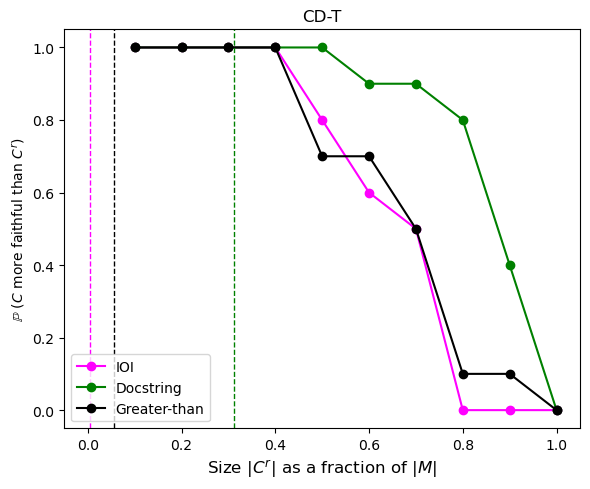

In [12]:
plt.rcParams['text.usetex'] = False

plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(6, 5))
## plot here

plt.plot([x/100 for x in range(10, 101, 10)], p_more_faithful_collect, label='IOI', marker='o', color='magenta')
plt.plot([x/100 for x in range(10, 101, 10)], p_more_faithful_collect_docstring, label='Docstring', marker='o', color='green')
plt.plot([x/100 for x in range(10, 101, 10)], p_more_faithful_collect_gt, label='Greater-than', marker='o', color='black')


plt.axvline(x=float(15/(144*21)), color='magenta', linestyle='--', linewidth=1)
plt.axvline(x=float(10/(32)), color='green', linestyle='--', linewidth=1)
plt.axvline(x=float(8/(144)), color='black', linestyle='--', linewidth=1)



plt.title("CD-T", fontsize=12)
plt.xlabel(r'Size $|C^{r}|$ as a fraction of $|M|$', fontsize=12)
plt.ylabel("$\mathbb{P}$ ($C$ more faithful than $C^{r}$)")
plt.xlim(-0.05, 1.05)
plt.legend(fontsize=10)

plt.legend(loc="lower left")
fig.tight_layout()

# Show the plot
plt.show()
fig.savefig('cdt-vs-random.pdf', dpi=300, bbox_inches='tight')

In [169]:
with open('REDACTED', 'w') as f:
    json.dump({i:float(x) for i, x in enumerate(p_more_faithful_collect)}, f)

In [8]:
p_more_faithful_collect_docstring_eap = [1, 1, 1, 1, 1, 1, 1, 0.9, 0.8, 0]
p_more_faithful_collect_gt_eap = [1, 1, 1, 1, 1, 1, 1, 0.6, 0.3, 0]

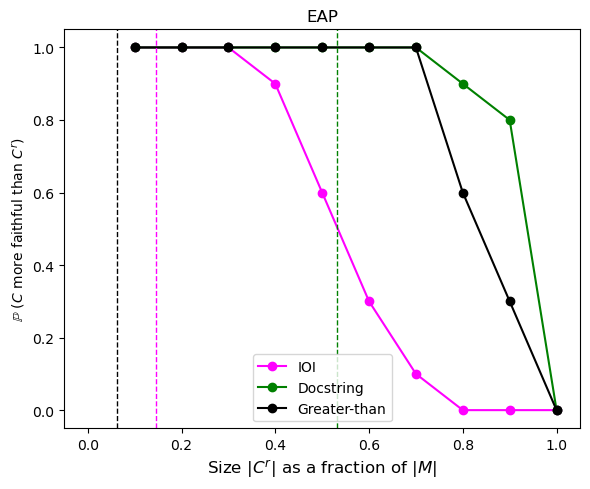

In [9]:
plt.rcParams['text.usetex'] = False

plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(6, 5))
## plot here
plt.title("EAP", fontsize=12)
plt.plot([x/100 for x in range(10, 101, 10)], p_more_faithful_collect_eap, label='IOI', marker='o', color='magenta')
plt.plot([x/100 for x in range(10, 101, 10)], p_more_faithful_collect_docstring_eap, label='Docstring', marker='o', color='green')
plt.plot([x/100 for x in range(10, 101, 10)], p_more_faithful_collect_gt_eap, label='Greater-than', marker='o', color='black')


plt.axvline(x=float(21/144), color='magenta', linestyle='--', linewidth=1)
plt.axvline(x=float(17/32), color='green', linestyle='--', linewidth=1)
plt.axvline(x=float(9/(144)), color='black', linestyle='--', linewidth=1)




plt.xlabel(r'Size $|C^{r}|$ as a fraction of $|M|$', fontsize=12)
plt.ylabel("$\mathbb{P}$ ($C$ more faithful than $C^{r}$)")
plt.xlim(-0.05, 1.05)
plt.legend(loc="lower left")
plt.legend(fontsize=10)
fig.tight_layout()


# Show the plot
plt.show()
fig.savefig('eap-vs-random.pdf', dpi=300, bbox_inches='tight')
# fig.savefig('REDACTED', dpi=300, bbox_inches='tight')

In [107]:
p_more_faithful_collect_ioi = [x[1] for x in {"0": 1.0, "1": 1.0, "2": 1.0, "3": 0.9, "4": 0.6, "5": 0.3, "6": 0.1, "7": 0.0, "8": 0.0, "9": 0.0}.items()]